In [6]:
import os
import logging
import pandas as pd
import numpy as np

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


raw_dir = "/home/peterr/macocu/taskB/data/raw"
interim_dir = "/home/peterr/macocu/taskB/data/interim"
final_dir = "/home/peterr/macocu/taskB/data/final"

In this notebook we shall repeat the keyness score calculation and identify top N lexems in every language.

In [2]:
def get_N_tokens(N=5000, path="/home/peterr/macocu/taskB/task4/toy_tokens.csv") -> set:
    import pandas as pd
    import numpy as np
    df = pd.read_csv("toy_tokens.csv", index_col=0)
    NUM_FEATS = N

    for column in df.columns:
        new_column_name = column + "_f"
        corpus_size = df[column].sum()
        df[new_column_name] = df[column] * 1e6 / corpus_size

    N = 1

    df["HR_SR"] = (df["hrwac_head_pp_f"] + N ) / (df["srwac_head_pp_f"] + N)
    df["SR_HR"] = (df["srwac_head_pp_f"] + N ) / (df["hrwac_head_pp_f"] + N)

    df["HR_CNR"] = (df["hrwac_head_pp_f"] + N ) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_HR"] = (df["cnrwac_head_pp_f"] + N ) / (df["hrwac_head_pp_f"] + N)

    df["HR_BS"] = (df["hrwac_head_pp_f"] + N ) / (df["bswac_head_pp_f"] + N)
    df["BS_HR"] = (df["bswac_head_pp_f"] + N ) / (df["hrwac_head_pp_f"] + N)

    df["BS_SR"] = (df["bswac_head_pp_f"] + N ) / (df["srwac_head_pp_f"] + N)
    df["SR_BS"] = (df["srwac_head_pp_f"] + N ) / (df["bswac_head_pp_f"] + N)

    df["BS_CNR"] = (df["bswac_head_pp_f"] + N ) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_BS"] = (df["cnrwac_head_pp_f"] + N ) / (df["bswac_head_pp_f"] + N)

    df["CNR_SR"] = (df["cnrwac_head_pp_f"] + N ) / (df["srwac_head_pp_f"] + N)
    df["SR_CNR"] = (df["srwac_head_pp_f"] + N ) / (df["cnrwac_head_pp_f"] + N)

    combos = ['HR_SR', 'SR_HR', 'HR_CNR', 'CNR_HR', 'HR_BS', 'BS_HR', 'BS_SR', 'SR_BS', 'BS_CNR', 'CNR_BS', 'CNR_SR', 'SR_CNR']

    important_features = set()

    for lang_comb in combos:
        s = df.sort_values(lang_comb, ascending=False)[lang_comb]
        current_features = s.index[:NUM_FEATS].values
        important_features = important_features.union(set(current_features))
    important_features.remove(np.nan)
    return important_features

In [3]:
feats = get_N_tokens()

2022-01-03 10:16:26,645 - NumExpr defaulting to 8 threads.


Now we are ready for training dataset preparation

The tail dataset will be used to construct the training set for differenc classifiers. Documents shall be split on blank lines. Afterwards the dataset will have to be compiled also from Twitter dataset and SETimes dataset.

In [4]:

from typing import List
def read_and_split_file(path: str) -> List[str]:
    texts = list()
    chunk = ""
    with open(path, "r") as f:
        content = f.readlines()
    for line in content:
        # Handle splits
        if line == "\n":
            texts.append(chunk)
            chunk = ""
        # Filter only lowercase alphabetical words:
        from utils import is_alpha
        line = line.replace("\n", " ")
        words = [w if is_alpha(w) else " " for w in line.split(" ")]
        chunk += " ".join(words)
    return texts

texts, labels = list(), list()

files = [
"bswac_tail_pp",
"cnrwac_tail_pp",
"hrwac_tail_pp",
"srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang]*len_cur_texts)


In [7]:
train = pd.DataFrame(data={"text": texts, "labels": labels})


In [8]:
train.text[1]

'     se profesionalno ili rekreativno bavite biciklizmom ili jednostavno imate želju voziti se biciklom u netaknutoj prirodi pozivamo   da dođete na   u istoimeni hotel i etno selo      vam nudi mnogobrojne staze kako za obični tako i za brdski biciklizam    vlastiti bicikl ili ga pak ne želite vuči sa sobom na odmor    brinite mi mislimo na   te   osiguravamo najam bicikla po vrlo povoljnim cijenama    najma bicika smještaja u hotelu ili pak u jedno od kučica u etno selu i odlične hrane nodimo   raznovrsne masaže korištenje saune jacuzzija i hotelske fitness sale  '

Let's prepare the evaluation dataset:

In [9]:
import pickle

with open("/home/peterr/macocu/taskB/data/final/twitter_full_ds.pickle", "rb") as f:
    twitter_ds = pickle.load(f)

In [10]:
users = twitter_ds.keys()
languages = [twitter_ds[user]["language"] for user in users]
tweets = [" ".join(twitter_ds[user]["tweets"]) for user in users]

eval_df = pd.DataFrame(data={"text": tweets, "labels": languages})

Ok, on to classifier training.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=get_N_tokens(), lowercase=True)

In [13]:
train_vectors = vectorizer.fit_transform(train.text)
train_labels = train.labels

test_vectors = vectorizer.fit_transform(eval_df.text)
y_true = eval_df.labels

In [15]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

clf.fit(train_vectors.toarray(), train_labels)
y_pred = clf.predict(test_vectors.toarray())

Macro f1: 0.561
Micro f1: 0.785
Accuracy: 0.785


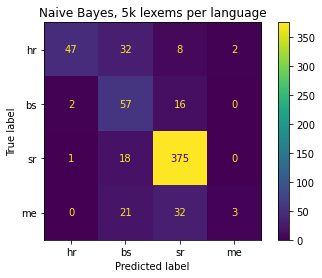

In [17]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

macro = f1_score(y_true, y_pred, labels=[
                 "hr", "sr", "bs", "me"], average="macro")
micro = f1_score(y_true, y_pred, labels=[
                 "hr", "sr", "bs", "me"],  average="micro")
acc = accuracy_score(y_true, y_pred)
print(f"Macro f1: {macro:0.3}\nMicro f1: {micro:0.3}\nAccuracy: {acc:0.3}")

cm = confusion_matrix(y_true, y_pred, labels=[
                 "hr",  "bs","sr", "me"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[
                 "hr", "bs", "sr",  "me"])
disp.plot()
plt.title("Naive Bayes, 5k lexems per language")
plt.savefig("images/13_Naive_Bayes_on_Twitter.png")
plt.show()

Macro f1: 0.608
Micro f1: 0.816
Accuracy: 0.816


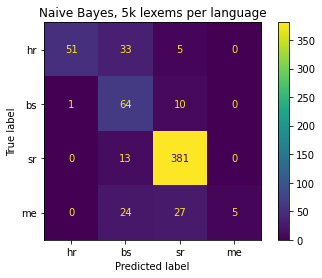

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=get_N_tokens(), lowercase=True, binary=True)

train_vectors = vectorizer.fit_transform(train.text)
train_labels = train.labels

test_vectors = vectorizer.fit_transform(eval_df.text)
y_true = eval_df.labels

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

clf.fit(train_vectors.toarray(), train_labels)
y_pred = clf.predict(test_vectors.toarray())

from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
LABELS = ["hr", "bs", "sr",  "me"]
macro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
acc = accuracy_score(y_true, y_pred)
print(f"Macro f1: {macro:0.3}\nMicro f1: {micro:0.3}\nAccuracy: {acc:0.3}")

cm = confusion_matrix(y_true, y_pred, labels=LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LABELS)
disp.plot()
plt.title("Naive Bayes, 5k lexems per language, binary vectorizer")
plt.savefig("images/13_Naive_Bayes_on_Twitter_binary_vectorizer.png")
plt.show()